# 1. Calculate the moving average of order values for each customer over their order history.
# 2. Calculate the cumulative sales per month for each year.
# 3. Calculate the year-over-year growth rate of total sales.
# 4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.
# 5. Identify the top 3 customers who spent the most money in each year.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector


db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "Abhi@123",
                            database = "ecommerce")

cur = db.cursor()
print("connected")

connected


# Calculate the moving average of order values for each customer over their order history.

In [13]:
query = """select customer_id, order_purchase_timestamp,payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as moving_avg
from
(select orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a;
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df.head()

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002


# Calculate the cumulative sales per month for each year.

In [16]:
query = """
SELECT 
    years,
    months,
    payment,
    SUM(payment) OVER (ORDER BY years, months) AS cumulative_sales
FROM (
    SELECT 
        YEAR(o.order_purchase_timestamp) AS years,
        MONTH(o.order_purchase_timestamp) AS months,
        ROUND(SUM(p.payment_value), 2) AS payment
    FROM orders o
    JOIN payments p
        ON o.order_id = p.order_id
    GROUP BY years, months
) a
ORDER BY years, months;

"""

cur.execute(query)
data = cur.fetchall()

columns = ["year", "month", "monthly_sales", "cumulative_sales"]
df = pd.DataFrame(data, columns=columns)
df


,year,month,monthly_sales,cumulative_sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


# Calculate the year-over-year growth rate of total sales.

In [19]:
query = """
    with a as(
    SELECT 
        YEAR(o.order_purchase_timestamp) AS years,
        ROUND(SUM(p.payment_value), 2) AS payment
    FROM orders o
    JOIN payments p
        ON o.order_id = p.order_id
    GROUP BY years order by years)

select years , ((payment - lag(payment, 1) over(order by years)) /
lag(payment, 1) over(order by years)) * 100 from a
"""

cur.execute(query)
data = cur.fetchall()

columns = ["year", "year_grouth",]
df = pd.DataFrame(data, columns=columns)
df



,year,year_grouth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# Calculate the year-over-year growth rate of total sales.

In [4]:
query = """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100 from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [20]:
query = """
WITH a AS (
    SELECT 
        c.customer_id,
        MIN(o.order_purchase_timestamp) AS first_order
    FROM ecommerce.customers c
    JOIN ecommerce.orders o
        ON c.customer_id = o.customer_id
    GROUP BY c.customer_id
),

b AS (
    SELECT DISTINCT
        a.customer_id
    FROM a
    JOIN ecommerce.orders o
        ON o.customer_id = a.customer_id
       AND o.order_purchase_timestamp > a.first_order
       AND o.order_purchase_timestamp < DATE_ADD(a.first_order, INTERVAL 6 MONTH)
)

SELECT 
    ROUND(100.0 * COUNT(DISTINCT b.customer_id) 
          / COUNT(DISTINCT a.customer_id), 2) AS retention_percentage
FROM a
LEFT JOIN b
    ON a.customer_id = b.customer_id;
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0
0,0.00


# Identify the top 3 customers who spent the most money in each year.

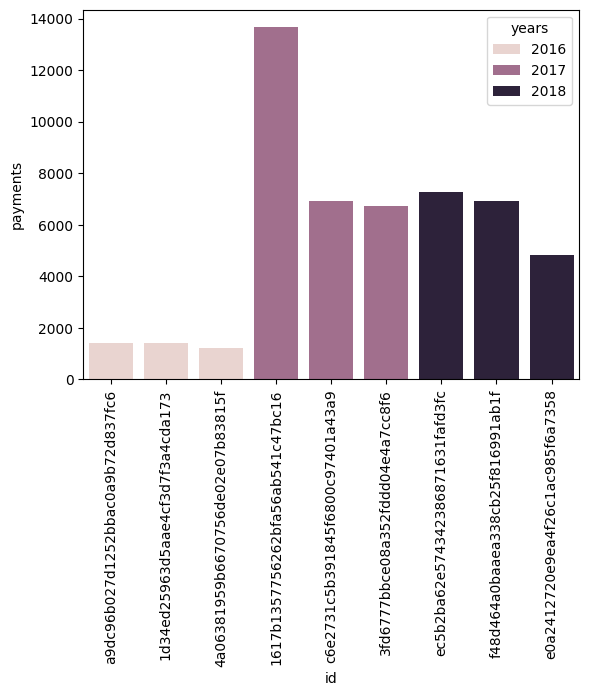

In [26]:
query = """
select years,customer_id ,payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a where d_rank <= 3 ; """

        

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "id", "payments","rank"])
sns.barplot(x = "id", y = "payments", data = df , hue = "years")
plt.xticks(rotation = 90)
plt.show()

In [ ]:
_